# Unsupervised Learning: Trade & Ahead

## Problem Statement

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries and data

In [5]:
# Installing the libraries with the specified version
!pip install scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.2 yellowbrick==1.5 -q --user
!pip install --upgrade -q jinja2

In [6]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#format numeric data for easier readability
pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded off to 2 decimal places

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=12)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="twilight",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [8]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="twilight",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="purple", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [9]:
#reading csv file into a pandas dataframe
ta = pd.read_csv('stock_data.csv')

# copying data to another varaible to preserve original data
df = ta.copy()

## Data Overview & Preprocessing

In [11]:
# check the number of columns and rows in the dataset
df.shape

(340, 15)

* Dataset has 340 rows and 15 columns

In [13]:
# print a sample of five rows randomly selected from the data
df.sample(n=5)

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
181,KO,Coca Cola Company,Consumer Staples,Soft Drinks,42.96,6.81,0.89,29,74,-1649000000,7351000000,1.69,4349704142.00,25.42,-1.47
54,CB,Chubb Limited,Financials,Property & Casualty Insurance,116.85,13.19,0.94,10,99,1120000000,2834000000,8.71,325373134.30,13.42,-17.47
7,AEE,Ameren Corp,Utilities,MultiUtilities,43.23,2.17,1.12,9,14,287000000,636000000,2.60,244615384.60,16.63,-0.72
36,AVGO,Broadcom,Information Technology,Semiconductors,145.15,17.90,1.85,29,163,218000000,1364000000,2.86,1044055944.00,18.25,3.95
72,CMS,CMS Energy,Utilities,MultiUtilities,36.08,1.95,1.04,14,12,39000000,537000000,1.90,282631578.90,18.99,0.06


In [14]:
# print each data type of each column within the datset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

In [15]:
# check for duplicate values
df.duplicated().sum()

0

* Dataset has no duplicate or missing values 
* All columns with dtype object should be converted to dtype category in order to conserve memory

In [17]:
# convert all columns with dtype object into category
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [18]:
# dropping the ticker symbol column, as it does not provide any useful information
df.drop("Ticker Symbol", axis=1, inplace=True)

In [19]:
# confirm conversions and drop successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Security                      340 non-null    category
 1   GICS Sector                   340 non-null    category
 2   GICS Sub Industry             340 non-null    category
 3   Current Price                 340 non-null    float64 
 4   Price Change                  340 non-null    float64 
 5   Volatility                    340 non-null    float64 
 6   ROE                           340 non-null    int64   
 7   Cash Ratio                    340 non-null    int64   
 8   Net Cash Flow                 340 non-null    int64   
 9   Net Income                    340 non-null    int64   
 10  Earnings Per Share            340 non-null    float64 
 11  Estimated Shares Outstanding  340 non-null    float64 
 12  P/E Ratio                     340 non-null    floa

* The 14 columns have three different dtypes: category (3), float64 (7), int64 (4)
* dtypes of columns follow logically according to their respective columns

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What does the distribution of stock prices look like?
2. The stocks of which economic sector have seen the maximum price increase on average?
3. How are the different variables correlated with each other?
4. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?
5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

In [23]:
# print statistical summary of all categorical columns
df.describe(include='category').T

,count,unique,top,freq
Security,340,340,3M Company,1
GICS Sector,340,11,Industrials,53
GICS Sub Industry,340,104,Oil & Gas Exploration & Production,16


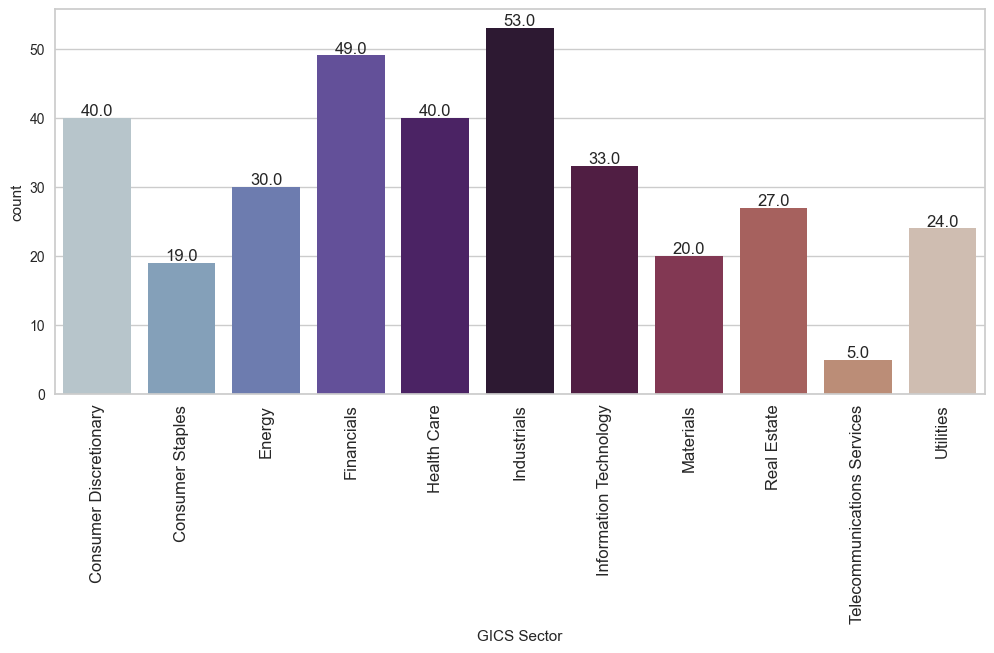

In [24]:
# create labeled barplot of stocks by sector
labeled_barplot(df, 'GICS Sector')

In [25]:
# print the top five sectors with the highest number of stocks
df["GICS Sector"].value_counts().head(n=5)

Industrials               53
Financials                49
Consumer Discretionary    40
Health Care               40
Information Technology    33
Name: GICS Sector, dtype: int64

* The stocks are drawn from 11 different industrial sectors, with no one sector comprising more than 16% of the dataset
* The top 4 of the 11 sectors: Industrials, Financials, Consumer Discretionary, and Health Care, comprise over half of the total number of stocks

#### GICS Sub Industry

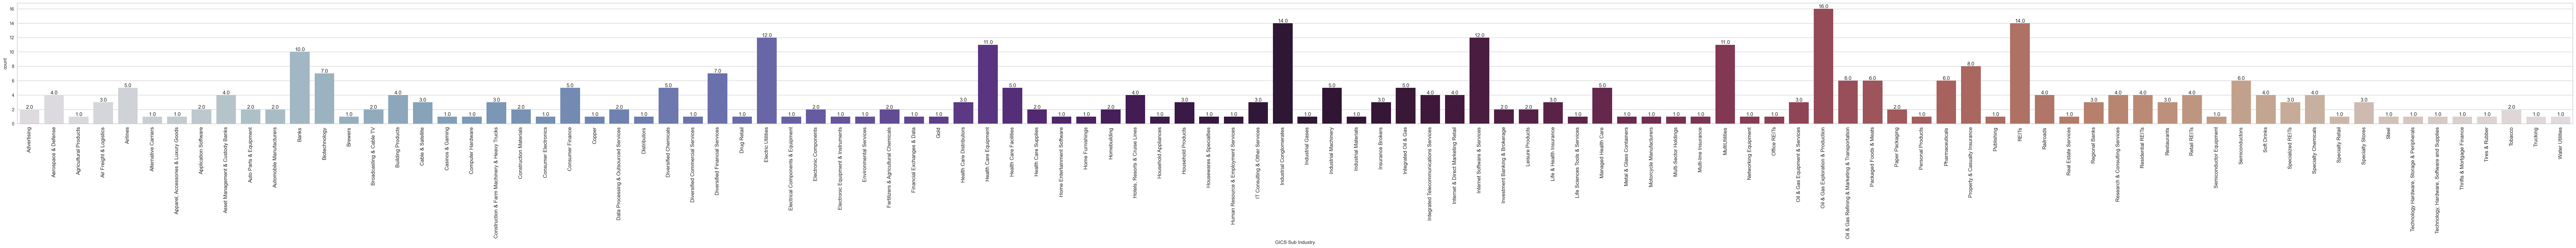

In [28]:
# create labeled barplot of stocks by sub industry
labeled_barplot(df, 'GICS Sub Industry')

In [29]:
# display the top five sub industries with the highest number of stocks
df['GICS Sub Industry'].value_counts().head(n=5)

Oil & Gas Exploration & Production    16
REITs                                 14
Industrial Conglomerates              14
Internet Software & Services          12
Electric Utilities                    12
Name: GICS Sub Industry, dtype: int64

* The dataset is comprised of stocks from 104 different subindustries, with no subindustry having more than 16 stocks in the dataset
* These observations indicate that the 340 stocks held within the dataset are highly diversified across sectors and subindustries

#### Numerical Columns

In [32]:
# print statistical summary of all numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Price,340.00,80.86,98.06,4.50,38.55,59.70,92.88,1274.95
Price Change,340.00,4.08,12.01,-47.13,-0.94,4.82,10.70,55.05
Volatility,340.00,1.53,0.59,0.73,1.13,1.39,1.70,4.58
ROE,340.00,39.60,96.55,1.00,9.75,15.00,27.00,917.00
Cash Ratio,340.00,70.02,90.42,0.00,18.00,47.00,99.00,958.00
Net Cash Flow,340.00,55537620.59,1946365312.18,-11208000000.00,-193906500.00,2098000.00,169810750.00,20764000000.00
Net Income,340.00,1494384602.94,3940150279.33,-23528000000.00,352301250.00,707336000.00,1899000000.00,24442000000.00
Earnings Per Share,340.00,2.78,6.59,-61.20,1.56,2.90,4.62,50.09
Estimated Shares Outstanding,340.00,577028337.75,845849595.42,27672156.86,158848216.10,309675137.80,573117457.32,6159292035.00
P/E Ratio,340.00,32.61,44.35,2.94,15.04,20.82,31.76,528.04


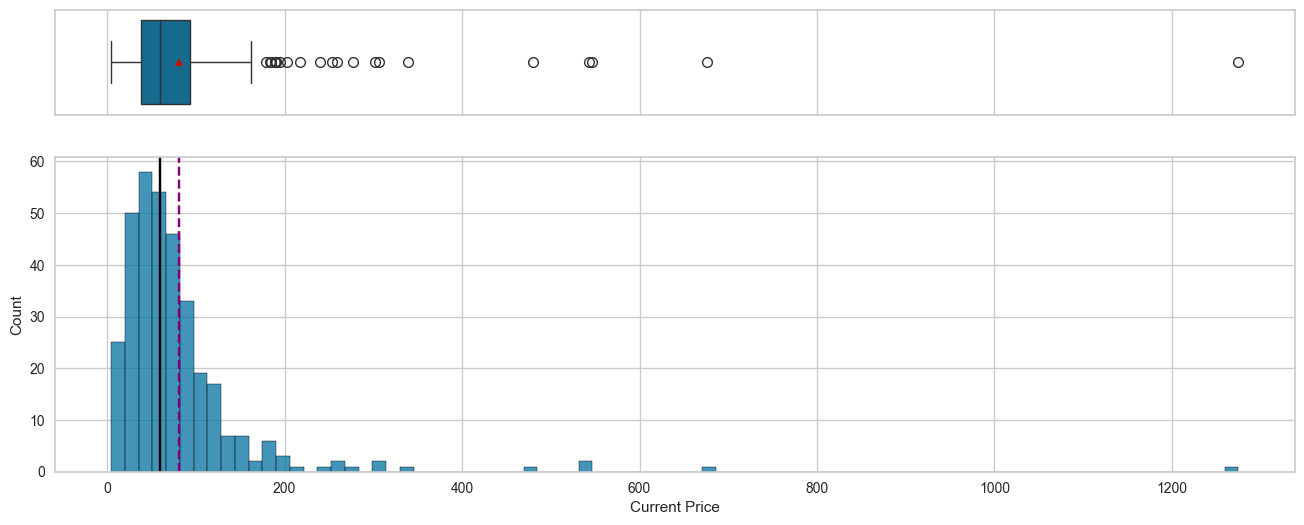

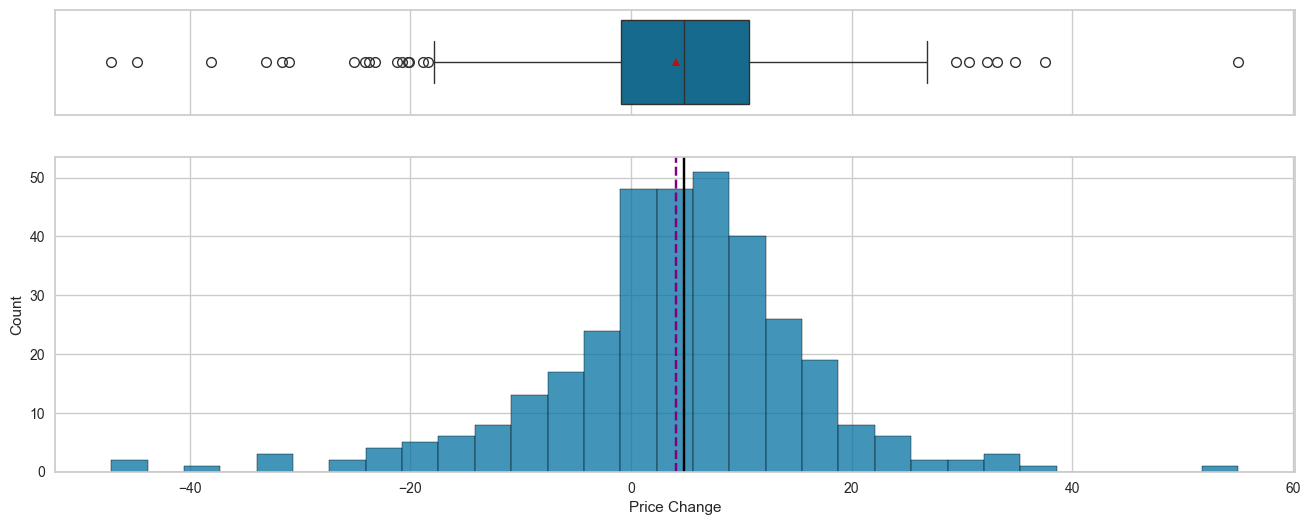

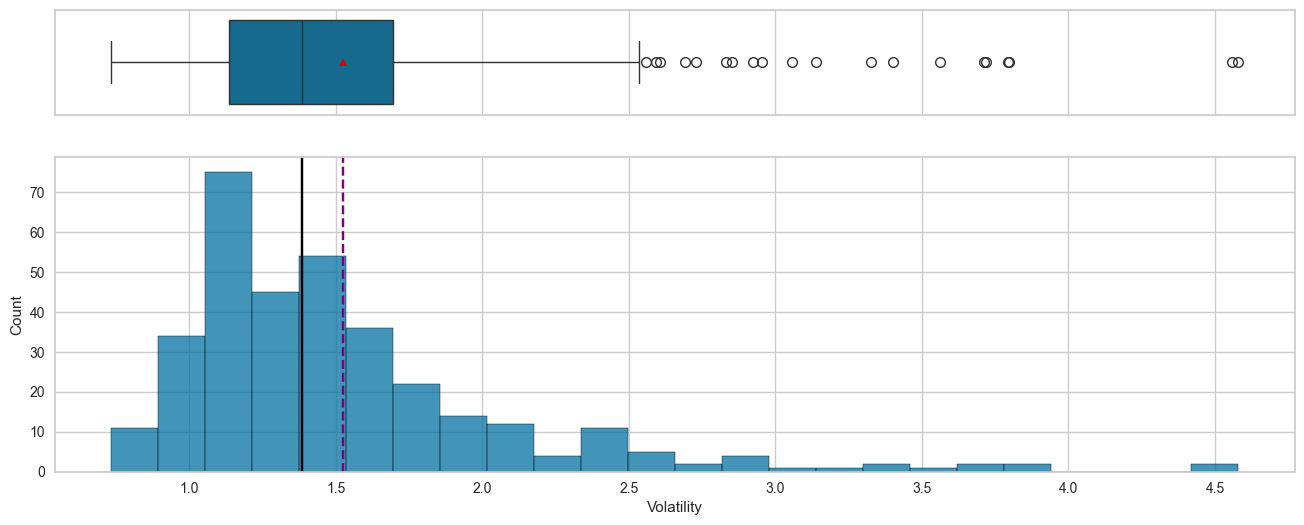

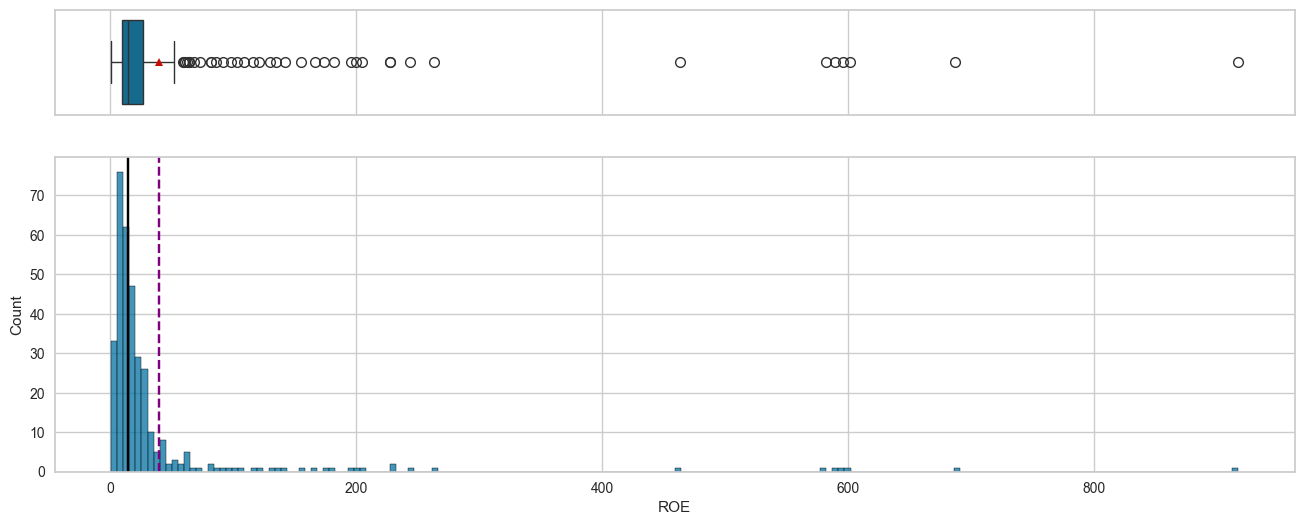

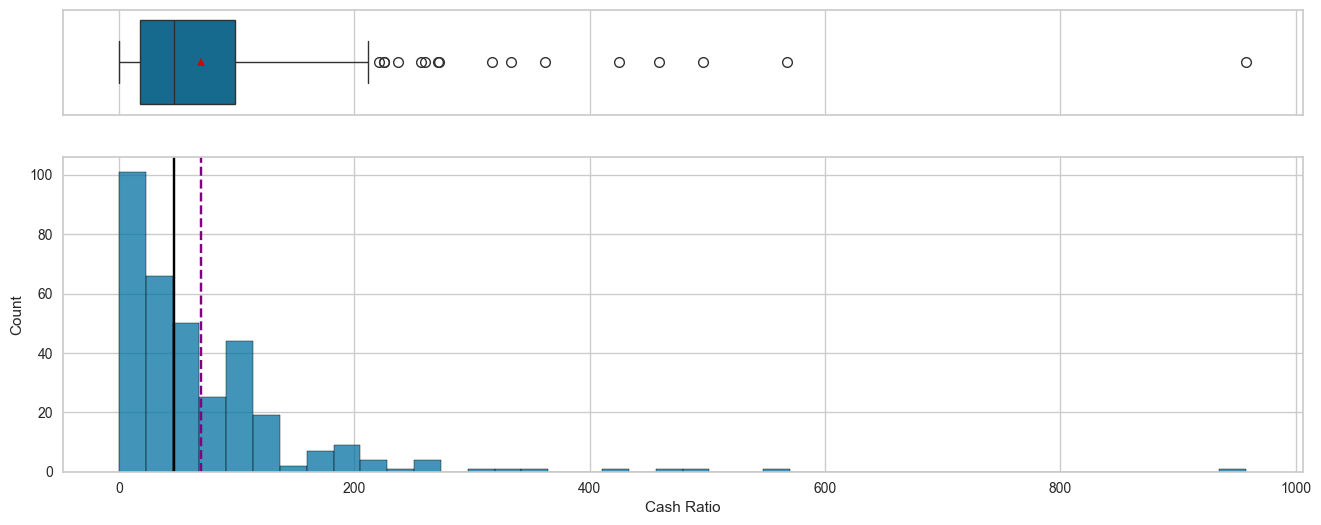

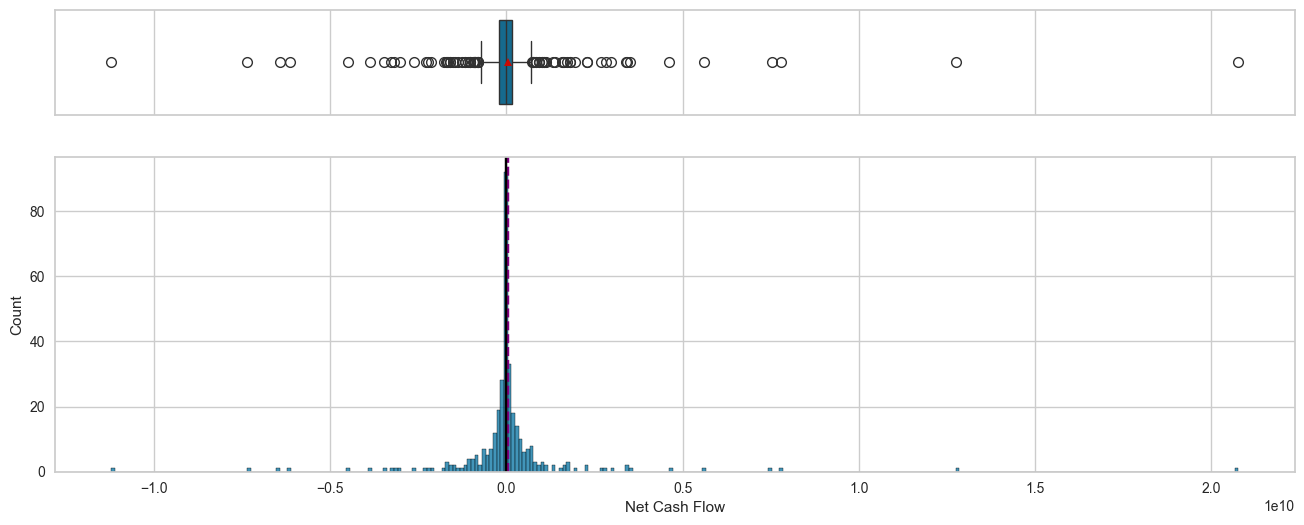

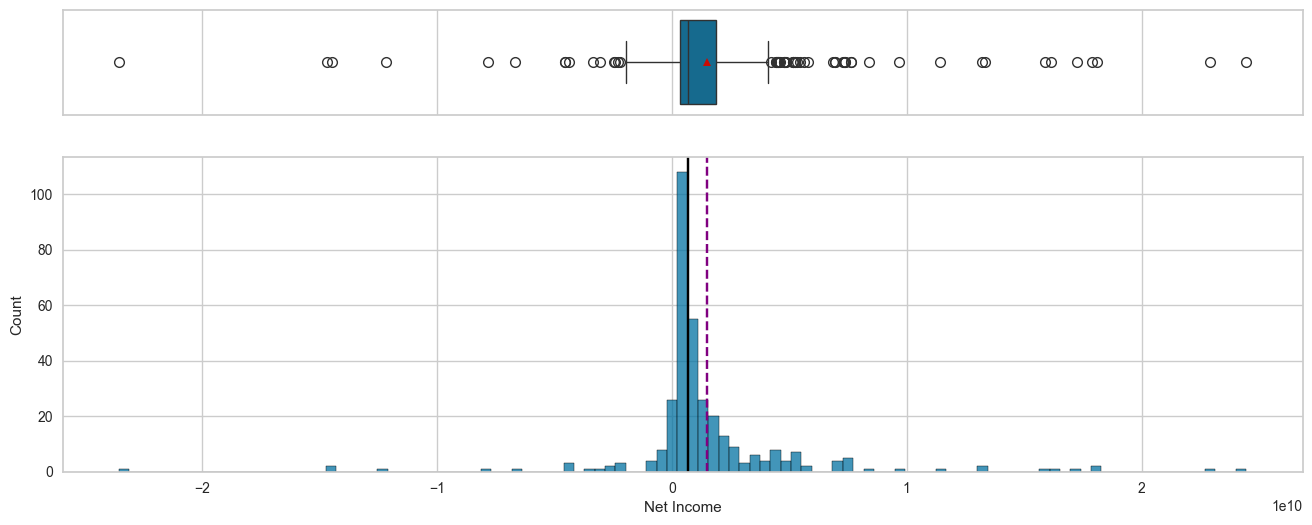

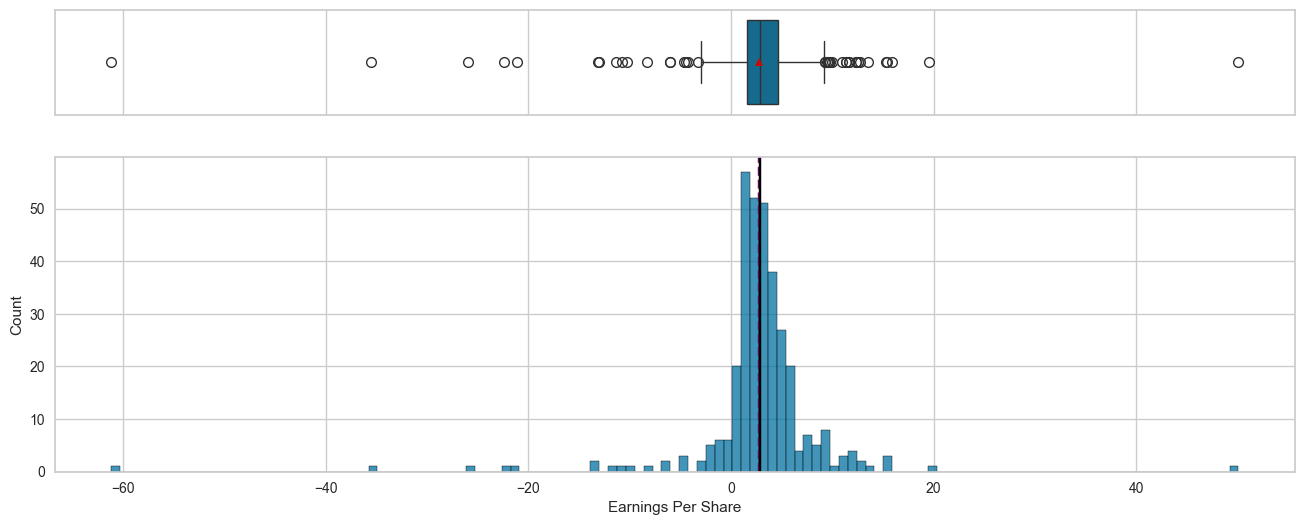

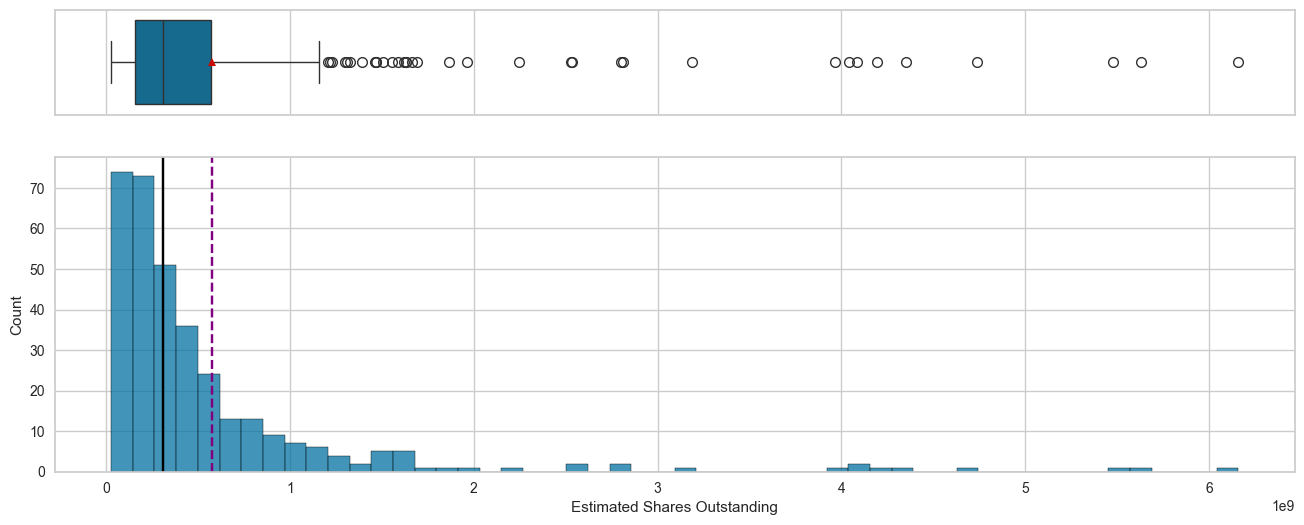

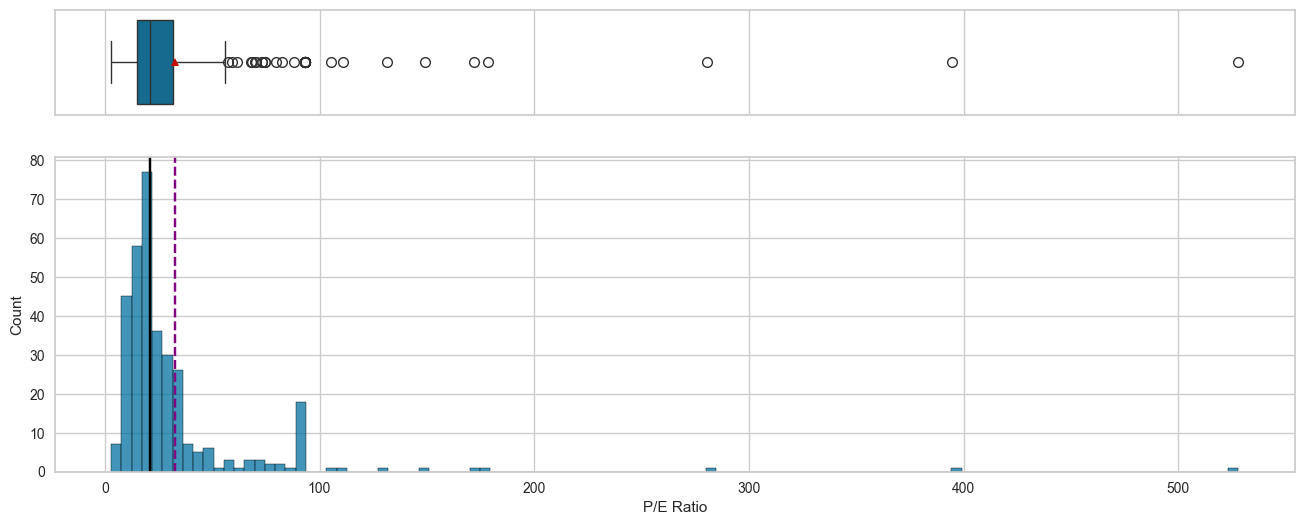

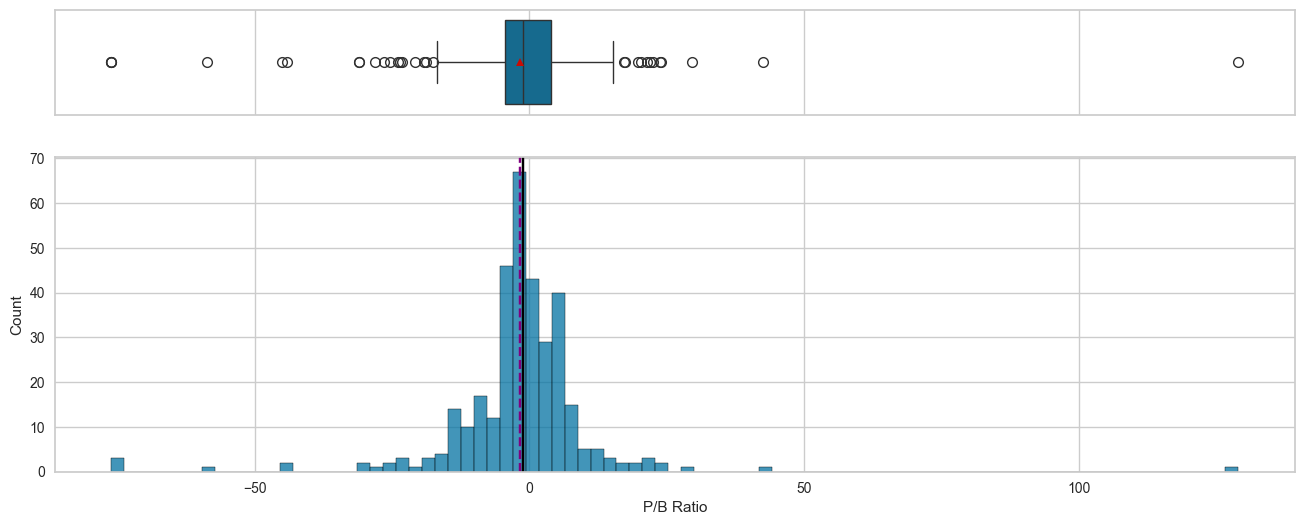

In [33]:
# print list of columns with numerical variables
num_col = df.select_dtypes(include=np.number).columns.tolist()

# print histograms and boxplots for all numerical columns
for col in num_col:
    histogram_boxplot(df, col)

#### `Current Price`

* The distribution is heavily right skewed, with 49 of the 340 stocks having twice the median value of all stocks
* As expected, no stock is listed at a value less than 0 dollars

#### `Price Change`

* The distribution leans towards lower volatilities, but there are long tails for both positive and negative price changes
* The most volatile stocks exhibit changes ranging from a 47% decrease to a 55% increase over 13 weeks

#### `Volatility`

* As anticipated, the distribution of standard deviations is right skewed

#### `Cash Ratio`, `ROE`

* As anticipated, both distributions are heavily right-skewed, with no stock listed with a value of less than 0 for either metric
* For instance, 24 stocks have returns on equity of less than 5%, while 25 stocks have returns exceeding 100%

#### `Net Income`, `EPS`

* As anticipated, the net income distribution is right-skewed with long tails on both the positive and negative sides 
    * This indicates that while most companies generate modest profits, some are either failing or highly successful 
* Within the dataset, 32 companies have a net income below 0 dollars. 
* Since EPS is derived from net income, it exhibits a similar distribution, with most values being low positive and 34 stocks showing negative values.

#### `Estimated Shares Outstanding`

* The distribution is highly right-skewed, but no stock has an unrealistic value of outstanding shares

#### `P/E Ratio`, `P/B Ratio`

* The distribution of P/E ratios is highly right skewed
* Interestingly, no stock has a negative ratio, despite several having a negative EPS, and no stock has a price listed below 0
* The distribution of P/B ratios is mostly concentrated around 0, with long tails on both the positive and negative sides
* For instance, 175 out of the 340 stocks fall below the 25th percentile or above the 75th percentile 
    * Additionally, 31 stocks are considered outliers

### Conclusions
* As expected, stocks present uncertain returns with high potential upsides, mostly modest returns, and the ever-present risk that the stock value could become worthless 
* All these variables have a few or several outliers, but none of these values appear unrealistic given the nature of stock prices and historical trends.

#### The stocks of which economic sector have seen the maximum price increase on average?

In [37]:
df.groupby('GICS Sector')['Price Change'].mean().sort_values()

GICS Sector
Energy                        -10.23
Utilities                       0.80
Industrials                     2.83
Financials                      3.87
Materials                       5.59
Consumer Discretionary          5.85
Real Estate                     6.21
Telecommunications Services     6.96
Information Technology          7.22
Consumer Staples                8.68
Health Care                     9.59
Name: Price Change, dtype: float64

* Stocks in the `Health Care` sectors display the highest average price increase over time

#### How are the different variables correlated with each other?

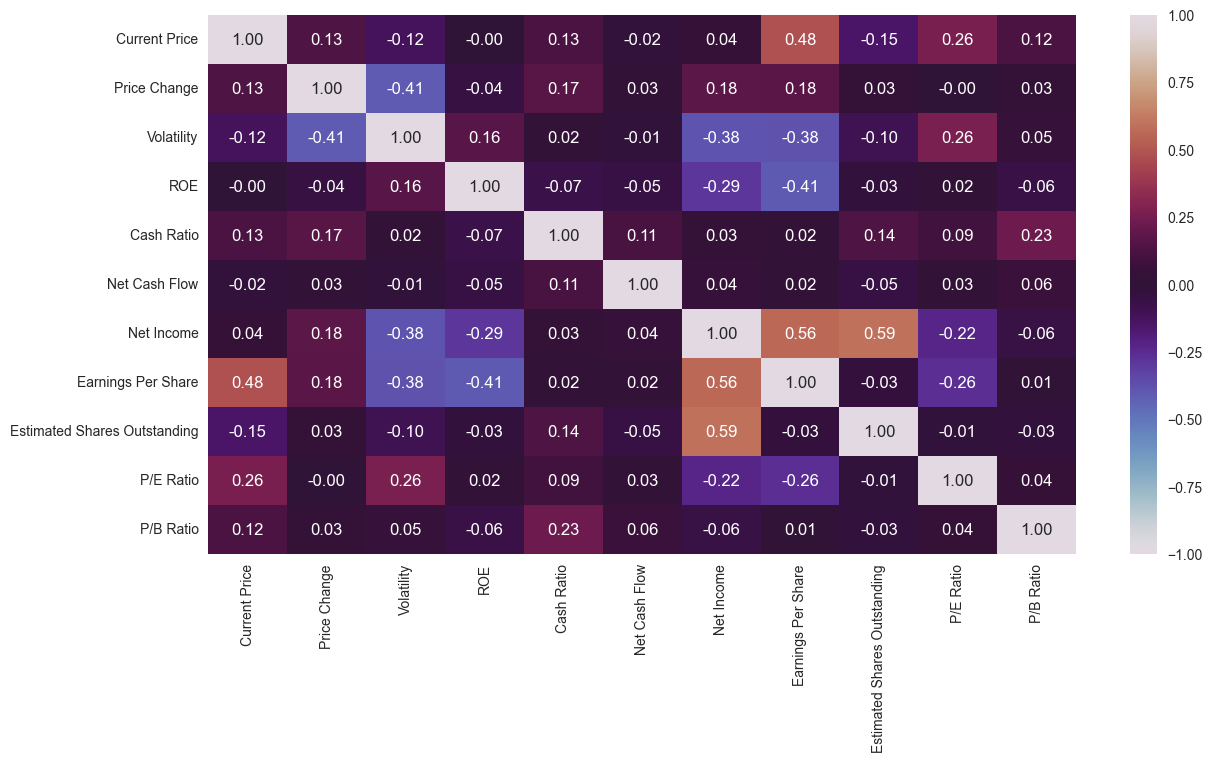

In [40]:
# print correlation heat map for numerical variables
plt.figure(figsize=(14, 7))
sns.heatmap(
    df[num_col].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap='twilight'
)
plt.show()

Several variables are moderately correlated (+/- .40) with one another
- `Volatility` is negatively correlated with `Price Change`, so as stocks become more volatile, the price is likely dropping
- `Net Income` is positively correlated with `Earnings Per Share` (EPS) and `Estimated Shares Outstanding`
- `Net Income` is also negatively correlated with `Volatility`, so as a company generates higher net income, its price is likely less volatile
- `EPS` is positively correlated with `Current Price`, so as EPS at a company rises, the prices are also highly likely to increase
- `EPS` is also negatively correlated with `ROE`, sp as more equity is generated by a company for shareholders, an equivalent amount of net income the following periods will generate a lower return

#### Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?

In [43]:
df.groupby('GICS Sector')['Cash Ratio'].mean().sort_values(ascending=False)

GICS Sector
Information Technology        149.82
Telecommunications Services   117.00
Health Care                   103.78
Financials                     98.59
Consumer Staples               70.95
Energy                         51.13
Real Estate                    50.11
Consumer Discretionary         49.58
Materials                      41.70
Industrials                    36.19
Utilities                      13.62
Name: Cash Ratio, dtype: float64

- Top two sector beasts when it comes to cash ratio is `Information Technology` and `Telecommunications`. This could be due to the fact that they are both newer, untapped, and less regulated industries, where companies are able to generate significant ratios compared to other sectors.
- At the bottom of the list is `Utilities`, generating the lowest cash ratio out of all the sectors, most likely due to the expected many regulations

#### P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

In [46]:
df.groupby('GICS Sector')['P/E Ratio'].mean().sort_values(ascending=False)

GICS Sector
Energy                        72.90
Information Technology        43.78
Real Estate                   43.07
Health Care                   41.14
Consumer Discretionary        35.21
Consumer Staples              25.52
Materials                     24.59
Utilities                     18.72
Industrials                   18.26
Financials                    16.02
Telecommunications Services   12.22
Name: P/E Ratio, dtype: float64

* `Energy` companies report the highest average P/E ratios of all sectors by a considerable margin, while `Telecommunication Services` reporting the lowest average P/E ratios
* It can be observed that `Information Technology`, `Real Estate`, and `Health Care` average similar ratios taking top spots following `Energy`

## K-means Clustering

In [49]:
# scale the dataset before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [50]:
# create a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

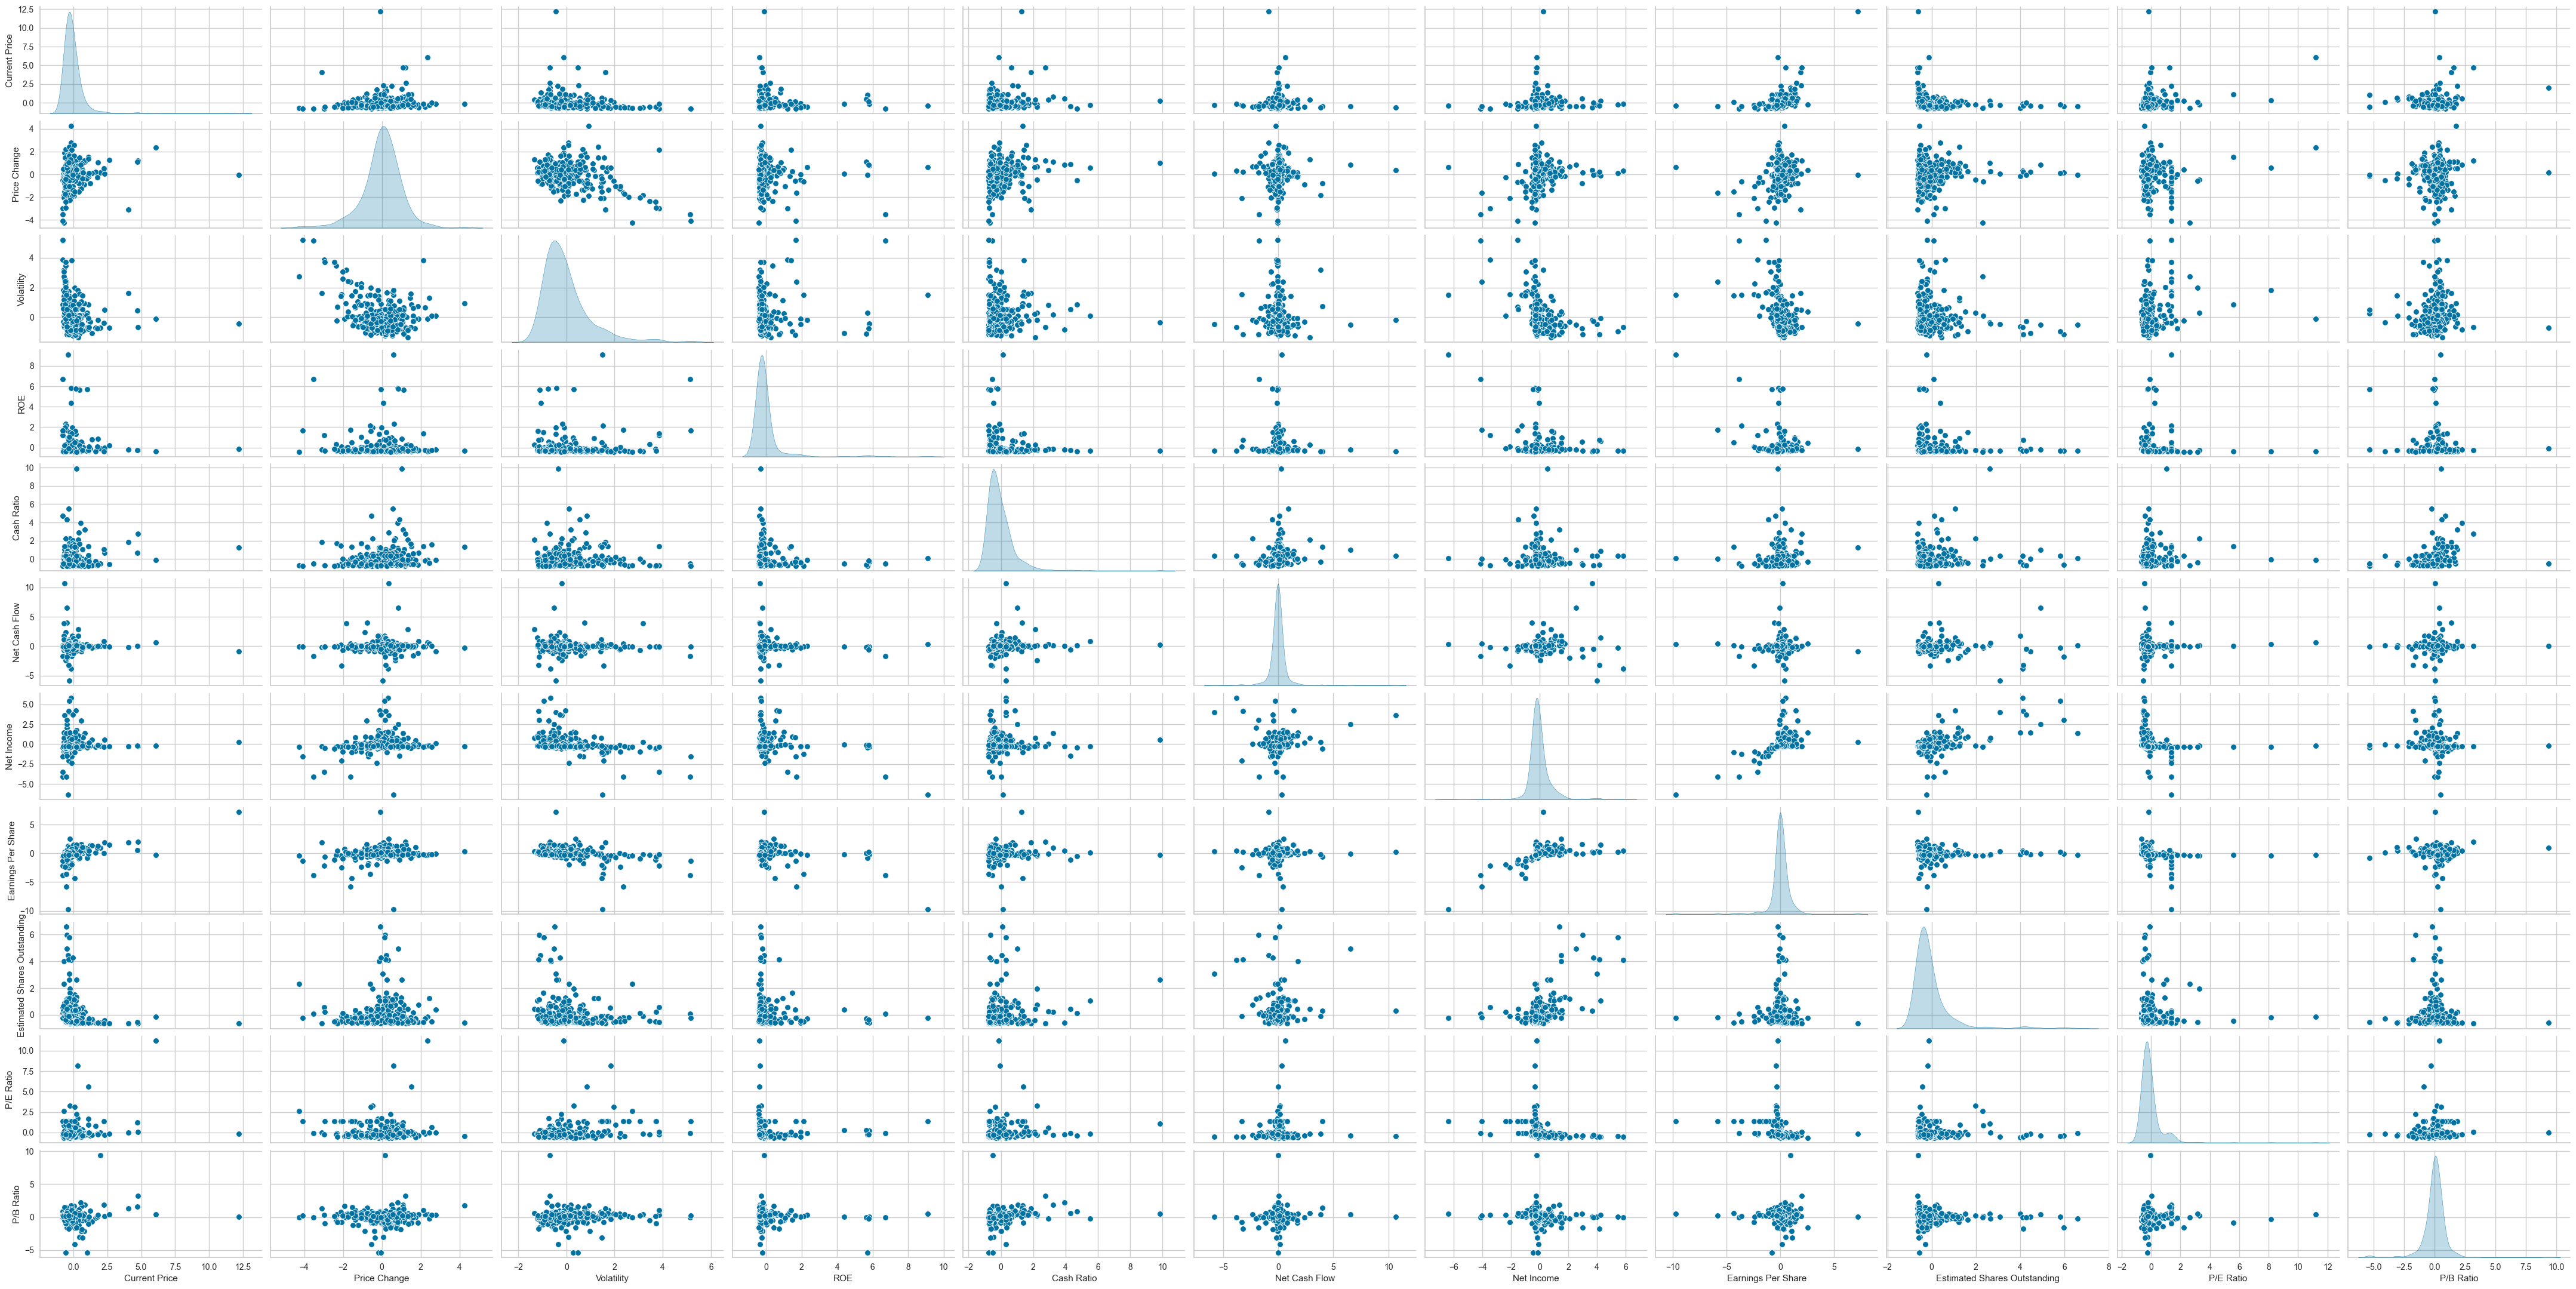

In [51]:
# create pairplot for scaled dataframe
sns.pairplot(subset_scaled_df, height=2,aspect=2 , diag_kind='kde', palette='twilight')
plt.show()

In [52]:
# print average distortions for range of Kmeans models fitted to scaled dataset
clusters = range(1, 11)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.384499097487295
Number of Clusters: 3 	Average Distortion: 2.2652173220958
Number of Clusters: 4 	Average Distortion: 2.1770961257432995
Number of Clusters: 5 	Average Distortion: 2.1059351899972185
Number of Clusters: 6 	Average Distortion: 2.068817263667957
Number of Clusters: 7 	Average Distortion: 2.010403621619149
Number of Clusters: 8 	Average Distortion: 1.9738239277644762
Number of Clusters: 9 	Average Distortion: 1.9283782062891306
Number of Clusters: 10 	Average Distortion: 1.8850010610813646


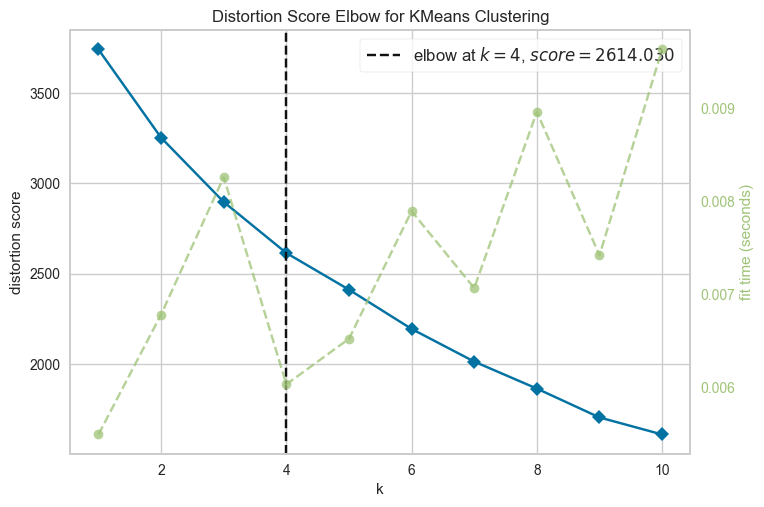

In [53]:
# fit KMeans model and use visualizer to indicate optimal K value
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1, 11), timings=True)
visualizer.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure
plt.show()

For n_clusters = 2, the silhouette score is 0.43969639509980457)
For n_clusters = 3, the silhouette score is 0.45797710447228496)
For n_clusters = 4, the silhouette score is 0.45017906939331087)
For n_clusters = 5, the silhouette score is 0.4599352800740646)
For n_clusters = 6, the silhouette score is 0.3985379248608659)
For n_clusters = 7, the silhouette score is 0.3868475076242907)
For n_clusters = 8, the silhouette score is 0.3886929719130642)
For n_clusters = 9, the silhouette score is 0.40581042332267614)
For n_clusters = 10, the silhouette score is 0.18011528994705786)


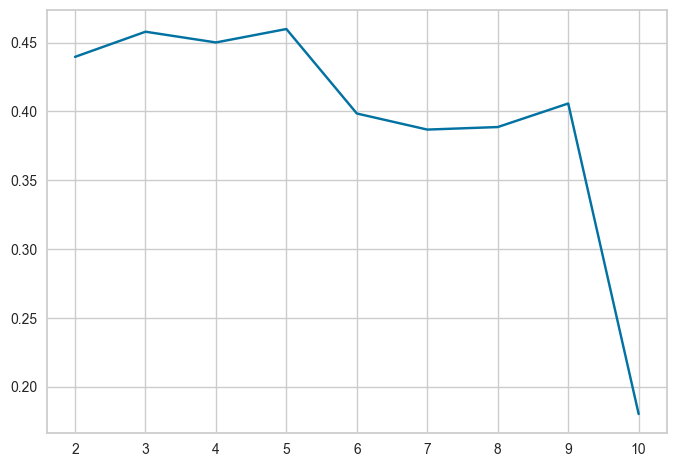

In [54]:
# fit KMeans model and provide silhouette scores for range of K clusters
sil_score = []
cluster_list = range(2, 11)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

# display scores in line graph
plt.plot(cluster_list, sil_score)
plt.show()

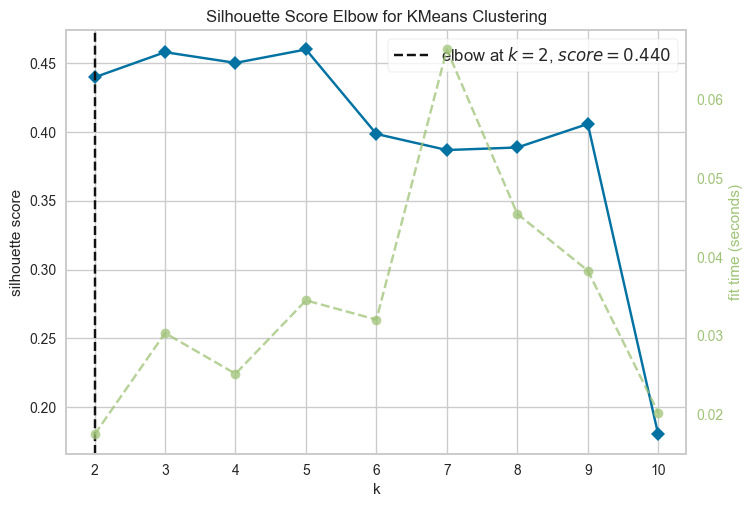

In [55]:
# fit KMeans model and use visualizer to indicate optimal K value
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 11), metric="silhouette", timings=True)
visualizer.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure
plt.show()

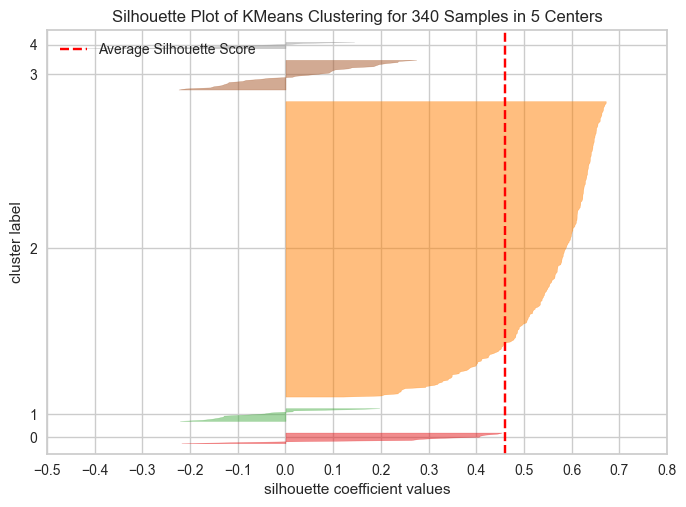

In [56]:
# find optimal number of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=42))
visualizer.fit(subset_scaled_df)
visualizer.show()
plt.show()

* Taking a look at the Elbow and Silhouette plots, the number of clusters allowing for the best performance appears to be 5

In [58]:
# create Kmeans cluster model
kmeans = KMeans(n_clusters=5, random_state=42)

# fit model to scaled dataset
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=5, random_state=42)

In [59]:
# adding Kmeans cluster labels to the original dataframe
df["KMeans_clusters"] = kmeans.labels_

In [60]:
# group dataset by Kmeans cluster labels
cluster_profile = df.groupby("KMeans_clusters").mean()

# add counts for number of stocks in each cluster
cluster_profile["Count"] = (
    df.groupby("KMeans_clusters")["Current Price"].count().values
)

In [61]:
cluster_profile.style.highlight_max(color="purple", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
KMeans_clusters,,,,,,,,,,,,
0,50.477272,5.588148,1.141171,31.545455,64.181818,-2581727272.727273,14675545454.545454,4.490909,4012176129.000000,14.010093,-5.356393,11
1,81.418719,10.536341,1.578634,17.000000,367.538462,3857062692.307693,3129067846.153846,2.197692,1334755181.584615,65.639418,6.235848,13
2,73.769121,5.466467,1.392827,34.632143,55.710714,4183132.142857,1443269353.571429,3.629625,430217149.035393,24.132318,-3.203999,280
3,38.808966,-13.680395,2.938240,106.034483,55.551724,-189825655.172414,-3578126517.241379,-8.657586,463121182.880690,85.946813,1.888901,29
4,585.527134,7.752090,1.508020,17.571429,159.142857,210520428.571429,804590428.571429,14.410000,116080574.760000,118.763084,33.713020,7


In [62]:
# display the names of the companies in each cluster
for cl in df["KMeans_clusters"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(df[df["KMeans_clusters"] == cl]["Security"].unique().to_list())
    print()

In cluster 2, the following companies are present:
['American Airlines Group', 'AbbVie', 'Abbott Laboratories', 'Adobe Systems Inc', 'Archer-Daniels-Midland Co', 'Ameren Corp', 'American Electric Power', 'AFLAC Inc', 'American International Group, Inc.', 'Apartment Investment & Mgmt', 'Assurant Inc', 'Arthur J. Gallagher & Co.', 'Akamai Technologies Inc', 'Albemarle Corp', 'Alaska Air Group Inc', 'Allstate Corp', 'Allegion', 'Applied Materials Inc', 'AMETEK Inc', 'Affiliated Managers Group Inc', 'Ameriprise Financial', 'American Tower Corp A', 'AutoNation Inc', 'Anthem Inc.', 'Aon plc', 'Amphenol Corp', 'Arconic Inc', 'Activision Blizzard', 'AvalonBay Communities, Inc.', 'Broadcom', 'American Water Works Company Inc', 'American Express Co', 'Boeing Company', 'Baxter International Inc.', 'BB&T Corporation', 'Bard (C.R.) Inc.', 'BIOGEN IDEC Inc.', 'The Bank of New York Mellon Corp.', 'Ball Corp', 'Bristol-Myers Squibb', 'Boston Scientific', 'BorgWarner', 'Boston Properties', 'Caterpillar

In [63]:
#print number of stocks within each sector for all of the clusters
for k in range(0,df['KMeans_clusters'].nunique()):
    print('The number of stocks within each GICS Sector for Cluster '+str(k)+' are:')
    print(df[df['KMeans_clusters']==k]['GICS Sector'].value_counts())
    print("   ")

The number of stocks within each GICS Sector for Cluster 0 are:
Financials                     3
Consumer Discretionary         2
Health Care                    2
Telecommunications Services    2
Consumer Staples               1
Energy                         1
Industrials                    0
Information Technology         0
Materials                      0
Real Estate                    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 1 are:
Health Care                    4
Information Technology         4
Consumer Discretionary         1
Consumer Staples               1
Energy                         1
Financials                     1
Telecommunications Services    1
Industrials                    0
Materials                      0
Real Estate                    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 2 are:
Industrial

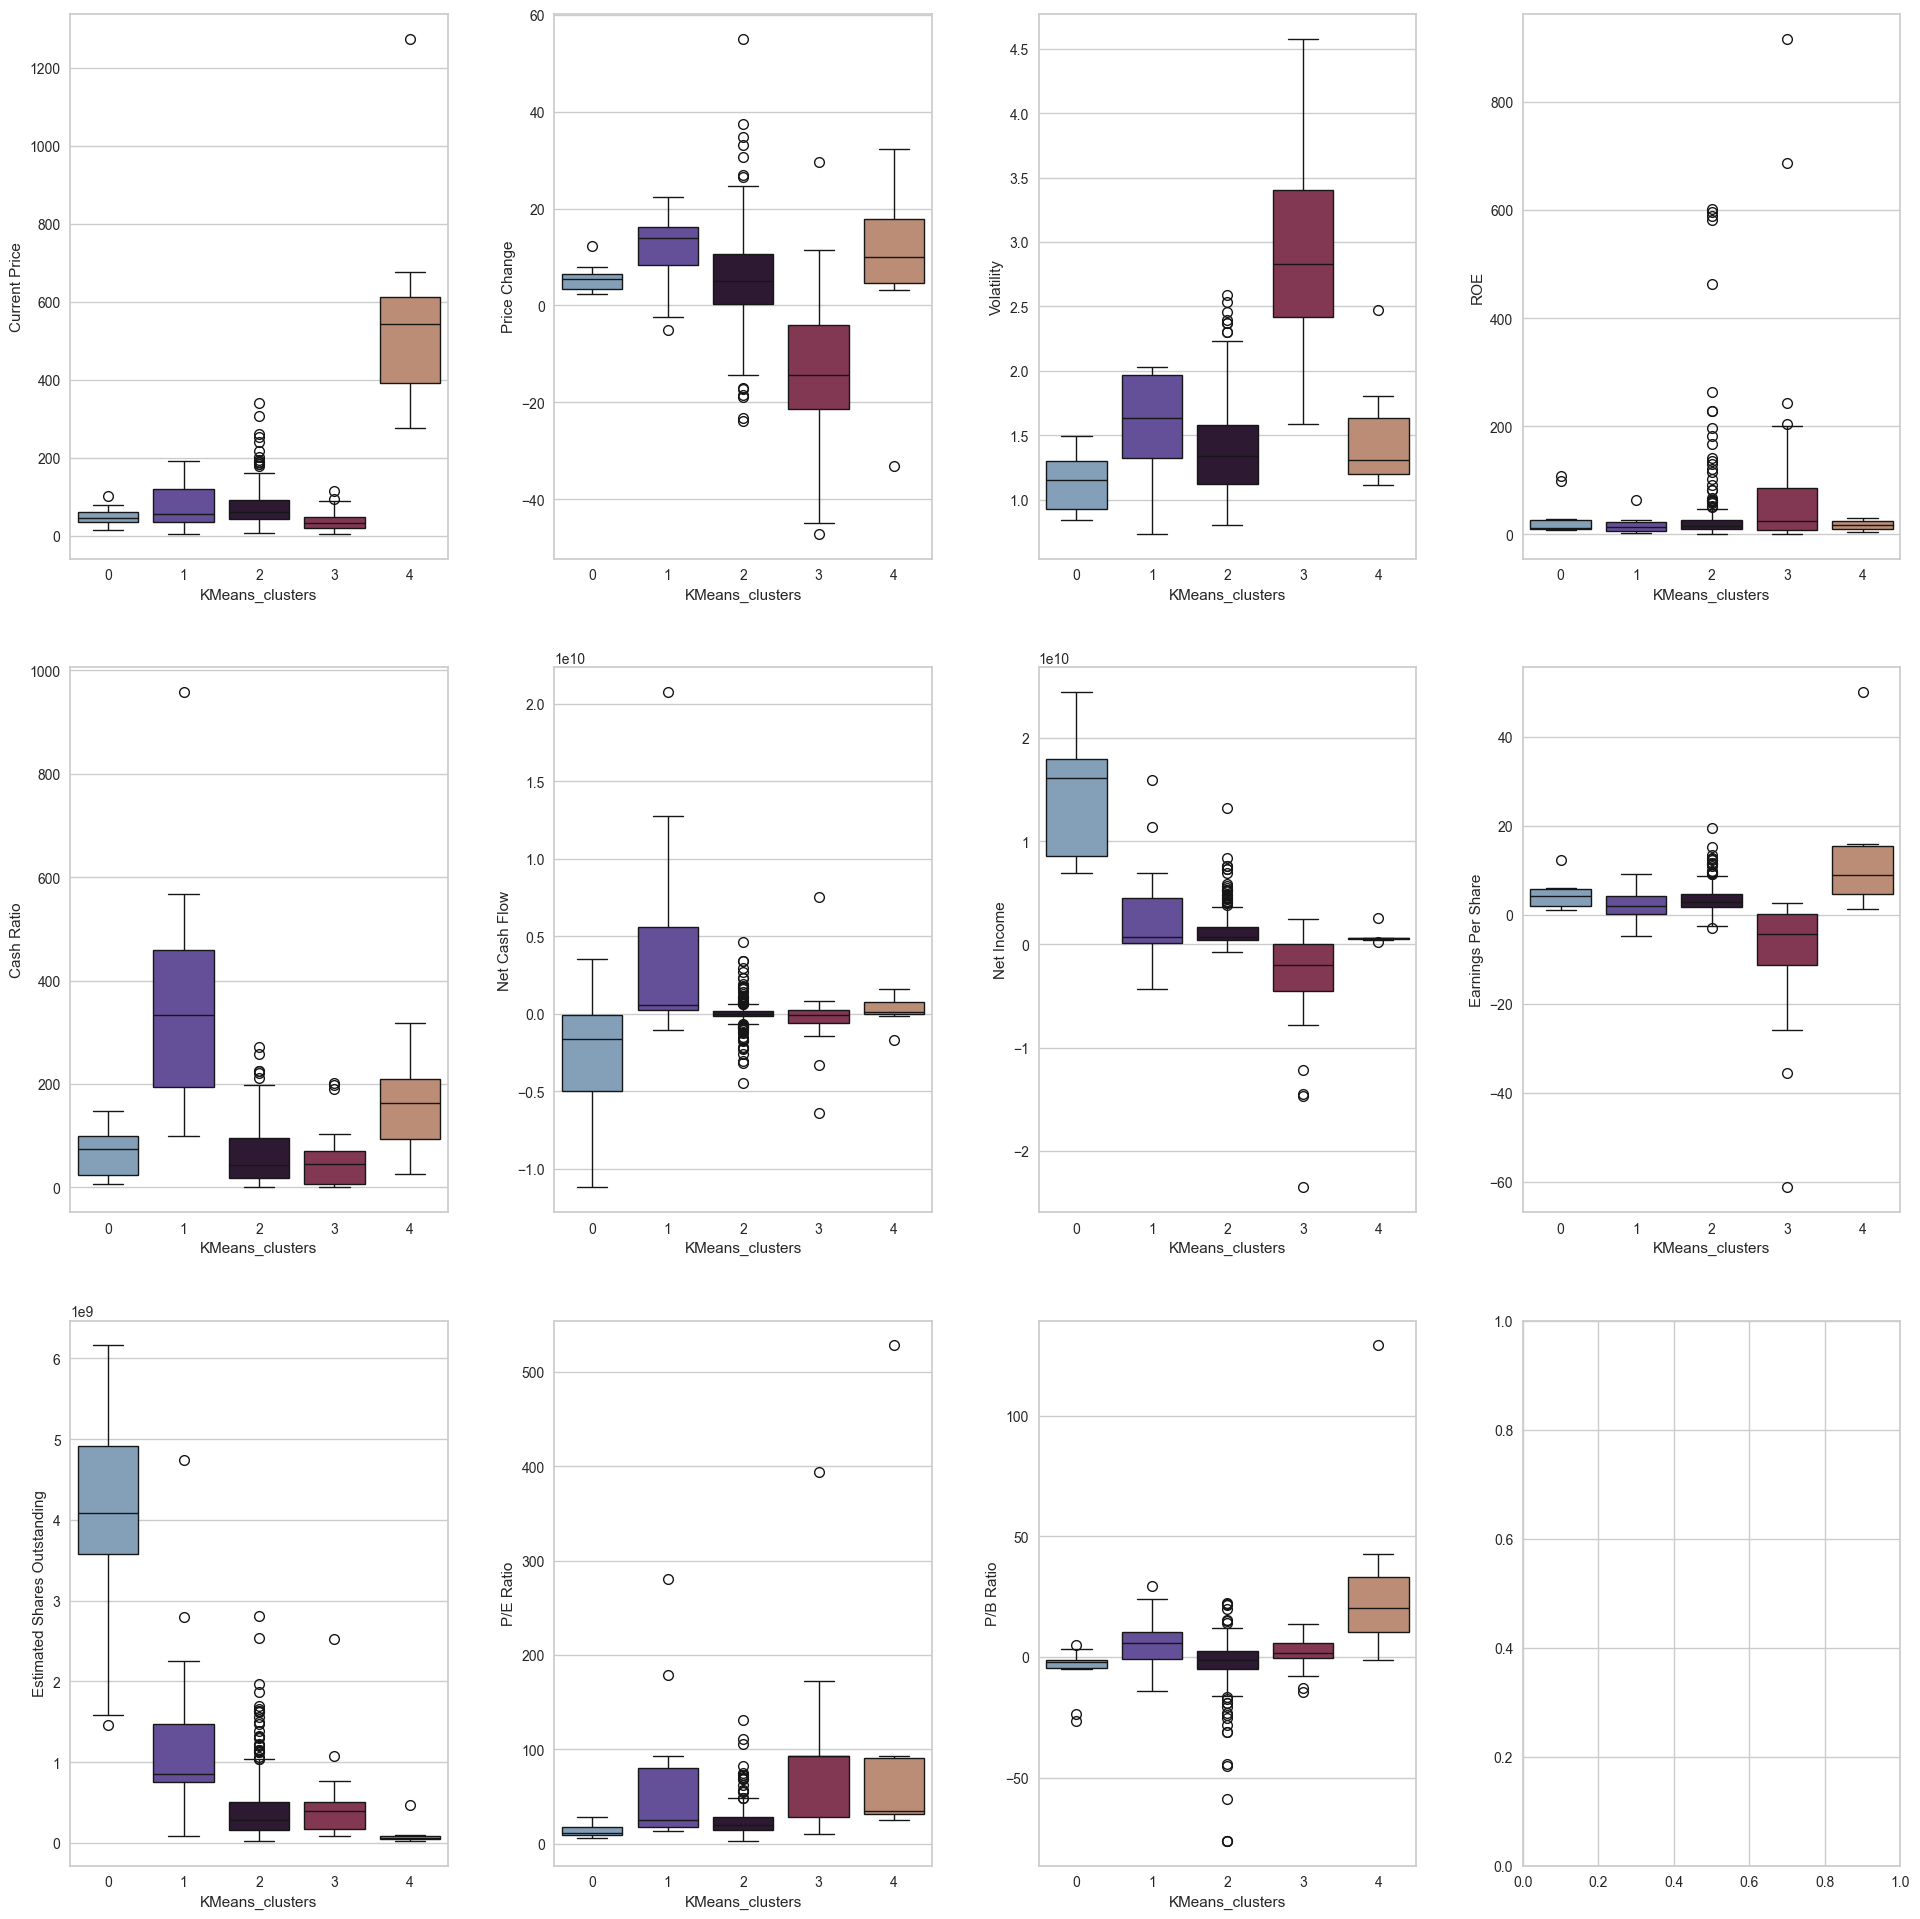

In [64]:
# print boxplots of numerical variables for each Kmeans cluster
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 11:
            sns.boxplot(
                ax=axes[ii][jj],
                data=df,
                y=df.columns[3+counter],
                x="KMeans_clusters",
                palette="twilight"
            )
            counter = counter + 1

fig.tight_layout(pad=3.0)

#### KMeans Clusters

**Cluster 0 - 'Major Corporations Across Key Industries'**

- 11 stocks, mostly within the `Financials`, `Health Care`, `Information Technology`, and `Consumer Discretionary` sectors


*Companies within this cluster exhibit:*


↓ Low volatility


↑ Majority of companies with the highest cash outflows


↑ Highest net incomes


↑ Highest number of shares outstanding


**Cluster 1 - 'Technology and Biotech Pioneers'**

- 13 stocks, mostly within the `Healthcare` and `IT` sectors



*Companies within this cluster exhibit:*


━ Moderate volatility


↑ Mostly profitable


↑ Most of the highest cash inflows and cash ratios


**Cluster 2 - 'Diverse Industry Leaders and Innovators'**

- 280 stocks (~84% of the entire dataset) drawn from all sectors present in the dataset


*Companies within this cluster exhibit:*


↓ Low P/E ratios


↑ Most of the outliers on negative P/B ratios


**Cluster 3 - 'Energy Sector Giants'**

- 29 stocks, a vast majority from the `Energy` sector


*Companies within this cluster exhibit:*


↓ Low stock prices, but ↑ high ROE


↑ High beta


↑ Majority of the most volatile stocks, especially those with outliers in price decreases


↓ Mostly negative earnings per share and net incomes

**Cluster 4 - 'High-Growth and Digital Innovators'**


- 7 stocks, mostly within `Health Care` and `Consumer Discretionary` sectors


*Companies within this cluster exhibit:*


↑ Most of stocks with the highest prices


↑ Favorable cash ratios


↑ Most favorable P/B ratios


↑ Most of the highest earnings per share

## Hierarchical Clustering

In [67]:
# specify list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# specify list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, round(c,4)
            )
        )
        print(" ")
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9232.
 
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873.
 
Cophenetic correlation for Euclidean distance and average linkage is 0.9423.
 
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8694.
 
Cophenetic correlation for Chebyshev distance and single linkage is 0.9063.
 
Cophenetic correlation for Chebyshev distance and complete linkage is 0.5989.
 
Cophenetic correlation for Chebyshev distance and average linkage is 0.9338.
 
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9127.
 
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9259.
 
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.7925.
 
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9247.
 
Cophenetic correlation for Mahalanobis distance and weighted linkage is 0.8708.
 
Cophenetic correlation for Cityblock dist

In [68]:
# print the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        round(high_cophenet_corr,4), high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9423, which is obtained with Euclidean distance and average linkage.


In [69]:
# specify list of linkage methods for euclidean distance metric
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print(
            "Cophenetic correlation for Euclidean distance and {} linkage is {}.".format(
                lm, round(c,4)
            )
        )
    print(" ")
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9232.
 
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873.
 
Cophenetic correlation for Euclidean distance and average linkage is 0.9423.
 
Cophenetic correlation for Euclidean distance and centroid linkage is 0.9314.
 
Cophenetic correlation for Euclidean distance and ward linkage is 0.7101.
 
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8694.
 


In [70]:
# print the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        round(high_cophenet_corr,4), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9423, which is obtained with average linkage.


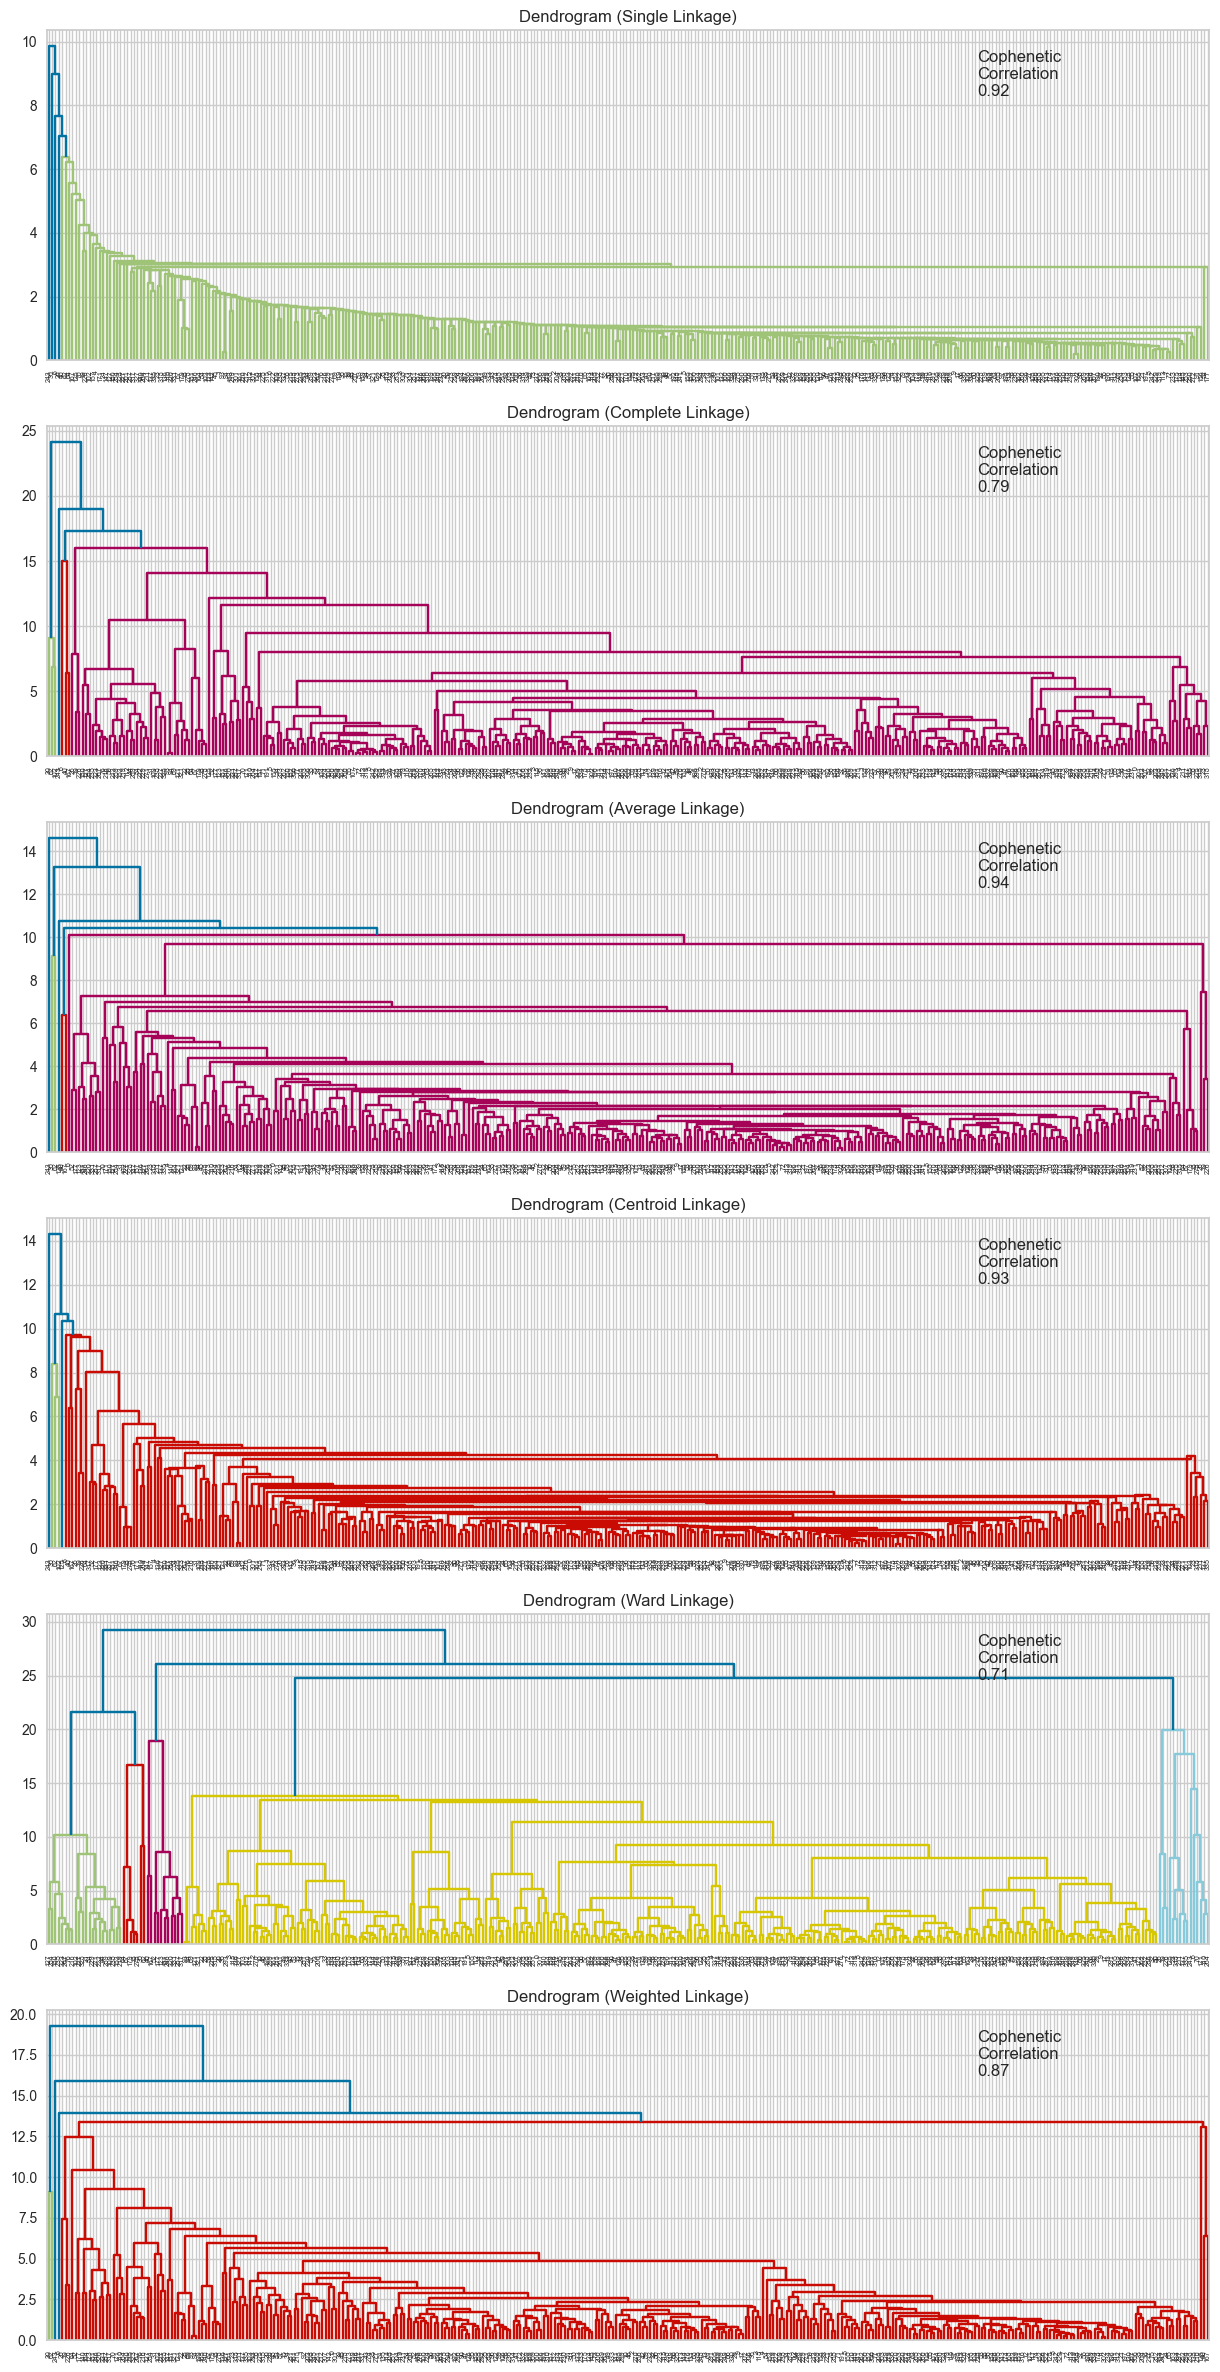

In [71]:
# specify list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# specify lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# enumerate through the list of linkage methods above
# plot the dendrogram and calculate the cophenetic correlation for each linkage method
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

* Comparing the above dendrograms, the cophentic correlation is the highest on the average centroid, and single linkages
* The dendrogram for average linkage appears to represent the clusters in a clear way, showing hierarchy.
* Based on the average linkage method, it seems that 5 clusters would be the optimal choice

In [73]:
Z = linkage(subset_scaled_df, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(subset_scaled_df))

In [74]:
hierarchy = AgglomerativeClustering(n_clusters=5, affinity='euclidean',  linkage='average')
hierarchy.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=5)

In [75]:
df_hierarchy = df.copy()
df_hierarchy.drop("KMeans_clusters", axis=1, inplace=True)
df_hierarchy['HC_clusters'] = hierarchy.labels_

In [76]:
# group dataset by hierarchical clusters
cluster_profile_h = df_hierarchy.groupby("HC_clusters").mean()

# add counts for the number of stocks per cluster
cluster_profile_h["Count"] = (
    df_hierarchy.groupby("HC_clusters")["Current Price"].count().values
)

# display dataframe with maximum values for each metric highlighted
cluster_profile_h.style.highlight_max(color="purple", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
HC_clusters,,,,,,,,,,,,
0,77.884243,4.105986,1.516865,35.320359,66.775449,-32825817.365269,1535255703.592814,2.903308,559027333.145509,32.437511,-1.781988,334
1,25.640000,11.237908,1.322355,12.500000,130.500000,16755500000.000000,13654000000.000000,3.295000,2791829362.100000,13.649696,1.508484,2
2,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,2
3,104.660004,16.224320,1.320606,8.000000,958.000000,592000000.000000,3669000000.000000,1.310000,2800763359.000000,79.893133,5.884467,1
4,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,1


* There are two clusters comprising one company each, two clusters comprising two companies each, and a single cluster comprising the remaining 334 companies
* The arrangement of these companies into clusters does not resolve the business problem effectively, as the clusters lack the necessary variability and diversity
* In contrast, the dendrogram for Ward linkage appears to provide the clearest clustering, but 5 still appearing to be the appropriate number of clusters

In [78]:
HCmodel = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', n_clusters=5)

In [79]:
subset_scaled_df["HC_clusters"] = HCmodel.labels_
df_hierarchy["HC_clusters"] = HCmodel.labels_

In [80]:
# group dataset by hierarchical clusters
cluster_profile_h = df_hierarchy.groupby("HC_clusters").mean()

# add counts for the number of stocks per cluster
cluster_profile_h["Count"] = (
    df_hierarchy.groupby("HC_clusters")["Current Price"].count().values
)

# display dataframe with maximum values for each metric highlighted
cluster_profile_h.style.highlight_max(color="purple", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,Count
HC_clusters,,,,,,,,,,,,
0,326.198218,10.563242,1.642560,14.400000,309.466667,288850666.666667,864498533.333333,7.785333,544900261.301333,113.095334,19.142151,15
1,84.355716,3.854981,1.827670,633.571429,33.571429,-568400000.000000,-4968157142.857142,-10.841429,398169036.442857,42.284541,-11.589502,7
2,42.848182,6.270446,1.123547,22.727273,71.454545,558636363.636364,14631272727.272728,3.410000,4242572567.290909,15.242169,-4.924615,11
3,72.760400,5.213307,1.427078,25.603509,60.392982,79951512.280702,1538594322.807018,3.655351,446472132.228456,24.722670,-2.647194,285
4,36.440455,-16.073408,2.832884,57.500000,42.409091,-472834090.909091,-3161045227.272727,-8.005000,514367806.201818,85.555682,0.836839,22


In [81]:
# display the names of the companies in each cluster
for cl in df_hierarchy["HC_clusters"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(df_hierarchy[df_hierarchy["HC_clusters"] == cl]["Security"].unique().to_list())
    print()

In cluster 3, the following companies are present:
['American Airlines Group', 'AbbVie', 'Abbott Laboratories', 'Adobe Systems Inc', 'Analog Devices, Inc.', 'Archer-Daniels-Midland Co', 'Ameren Corp', 'American Electric Power', 'AFLAC Inc', 'American International Group, Inc.', 'Apartment Investment & Mgmt', 'Assurant Inc', 'Arthur J. Gallagher & Co.', 'Akamai Technologies Inc', 'Albemarle Corp', 'Alaska Air Group Inc', 'Allstate Corp', 'Applied Materials Inc', 'AMETEK Inc', 'Affiliated Managers Group Inc', 'Ameriprise Financial', 'American Tower Corp A', 'AutoNation Inc', 'Anthem Inc.', 'Aon plc', 'Amphenol Corp', 'Arconic Inc', 'Activision Blizzard', 'AvalonBay Communities, Inc.', 'Broadcom', 'American Water Works Company Inc', 'American Express Co', 'Boeing Company', 'Baxter International Inc.', 'BB&T Corporation', 'Bard (C.R.) Inc.', 'BIOGEN IDEC Inc.', 'The Bank of New York Mellon Corp.', 'Ball Corp', 'Bristol-Myers Squibb', 'Boston Scientific', 'BorgWarner', 'Boston Properties', 

In [82]:
# print the number of stocks in each GICS sector for each cluster
for k in range(0,df_hierarchy['HC_clusters'].nunique()):
    print('The number of stocks within each GICS Sector for Cluster '+str(k)+' are:')
    print(df_hierarchy[df_hierarchy['HC_clusters']==k]['GICS Sector'].value_counts())
    print("   ")

The number of stocks within each GICS Sector for Cluster 0 are:
Health Care                    5
Information Technology         4
Consumer Discretionary         3
Consumer Staples               1
Real Estate                    1
Telecommunications Services    1
Energy                         0
Financials                     0
Industrials                    0
Materials                      0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 1 are:
Consumer Staples               2
Energy                         2
Consumer Discretionary         1
Financials                     1
Industrials                    1
Health Care                    0
Information Technology         0
Materials                      0
Real Estate                    0
Telecommunications Services    0
Utilities                      0
Name: GICS Sector, dtype: int64
   
The number of stocks within each GICS Sector for Cluster 2 are:
Financials

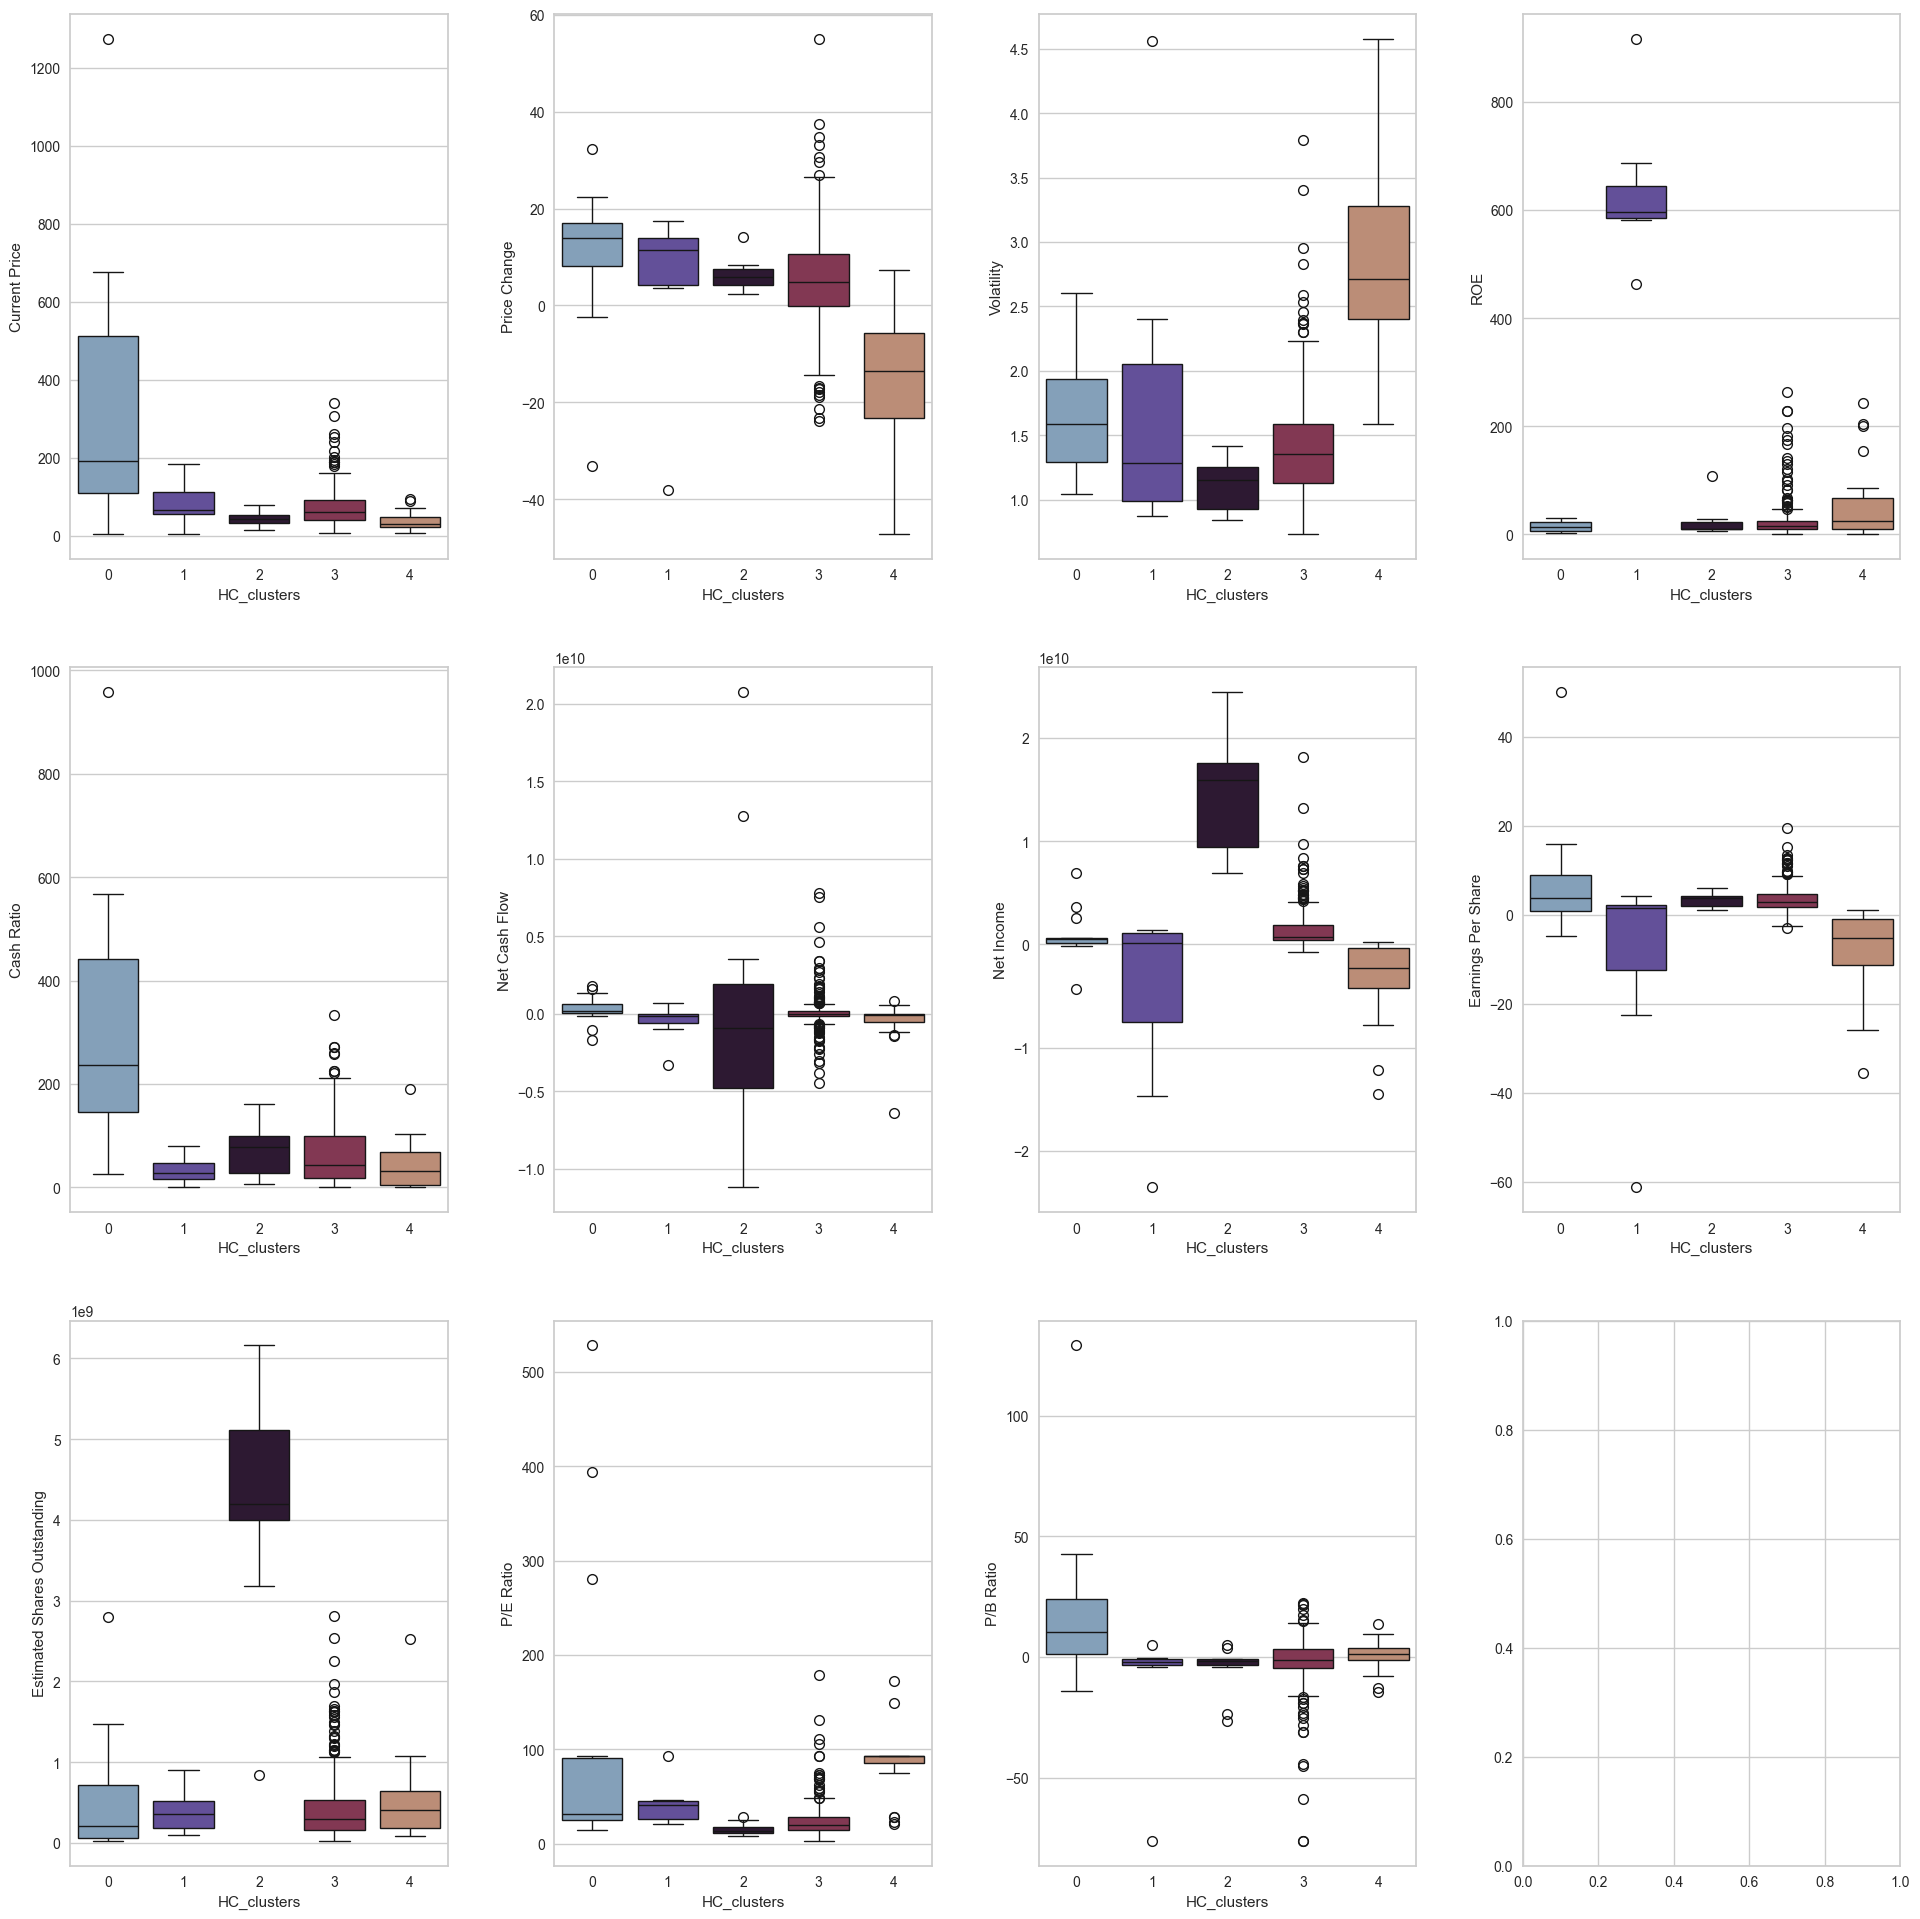

In [83]:
# print boxplots of numerical variables for each hierarchical cluster
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 11:
            sns.boxplot(
                ax=axes[ii][jj],
                data=df_hierarchy,
                y=df_hierarchy.columns[3+counter],
                x="HC_clusters",
                palette="twilight"
            )
            counter = counter + 1

fig.tight_layout(pad=3.0)

#### KMeans Clusters

**Cluster 0 - Growth, but at what Cost**


* 15 stocks, within `Health Care`, `Information Technology`, and `Consumer Discretionary` sectors


*Companies within this cluster exhibit:*


↑ Majority of stocks with the highest prices


↑ Substantial outliers in price-to-equity ratio


↑ Most favorable P/B ratios


↑ Most of the highest cash ratios

**Cluster 1 - Humble Beginnings, Boundless Success**


* 7 stocks, comprised mostly of stocks within the `Consumer Staples` and `Energy` sectors


*Companies within this cluster exhibit:*


↑ Highest returns-on-equity


↓ Lowest net incomes


↓ Mostly negative earnings per share


**Cluster 2 - Dow Jones Industrial Average**

* 11 stocks, comprised mostly of stocks within the `Financials` and `Telecommunications` sectors


*Companies within this cluster exhibit:*


↑ Majority of companies with highest inflows and outflows of cash


↑ Highest net incomes


↑ Highest number of shares outstanding

**Cluster 3 - Variety**

* 285 stocks (~84% of all stocks in the dataset) drawn from all sectors present in the dataset


*Companies within this cluster exhibit:*


Many outliers in price increases ↑, some outliers in price decreases ↓


— Some outliers in cash inflows and outflows


— Most outliers in P/B ratio

**Cluster 4 - Energized Investment**

* 22 stocks, a vast majority of which are in the Energy sector


*Companies within this cluster exhibit:*


— Most volatile stocks, particularly those with outliers in price decreases


↓ Mostly negative earnings per share and net incomes

## K-means vs Hierarchical Clustering

Which clustering technique took less time for execution?
* Both the Agglomerative Clustering model and the KMeans model fit the dataset within ~0.1s

Which clustering technique gave you more distinct clusters, or are they the same?
* Both algorithms group the data into similar clusters, with the majority of stocks in a one cluster and the remaining four clusters including 7-29 stocks

How many observations are there in the similar clusters of both algorithms?
* For each algorithm, employing 5 clusters resulted in well-defined groupings with ample observations in each, allowing for clear differentiation of the representative 'type' of stock within each cluster

How many clusters are obtained as the appropriate number of clusters from both algorithms?
* Similar clusters, about 5, were produced by both algorithms, driven by the outliers present across the 11 variables

## Actionable Insights and Recommendations

- *Trade&Ahead's* initial step involves identifying their clients' financial objectives, investment tendencies and risk tolerance. Subsequently, they could suggest a cluster aligning with these criteria as a potential stock portfolio tailored to meet their needs. 
- However, many of these clusters, characterized by the traits of the stocks they contain, basically mirror standard indexes like the Dow Jones Industrial Average and the S&P 500, which could fulfill these objectives more readily. 
- Alternatively, *Trade&Ahead* could leverage these clusters as a foundation for further analysis of financial statements, specifically to identify individual stocks that deviate from the "profile" of the cluster. If the selection of individual stocks constitutes a component of a client's investment strategy, *Trade&Ahead* may then pinpoint stocks poised to outperform their peers. For example, if the price rises ↑, buy the reccommendation. If the price falls ↓, sell the recommendation. 